**Dataset Handling and Loading**

# Data Loading and Splitting

In [ ]:
import zipfile

# Define paths
from google.colab import drive
drive.mount('/content/drive')

zip_path = '/content/drive/MyDrive/APS360 Team 5 Project/dataset.zip'
extract_path = '/content/extracted_dataset'

# Extract the zip file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Dataset extracted to", extract_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Dataset extracted to /content/extracted_dataset


**Image Transformation**

Apply rotation, padding, brightness change, and resize to 224x224.
224x224. Most widely used pretrained CNNs (like ResNet, VGG, AlexNet) expect an input size of 224x224, which allows easy use of these architectures for transfer learning.

The original images are 480x640

In [ ]:
from torchvision import transforms

# Define transformations for 640x480 images
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])


**Load the data**

In [ ]:
from torchvision import datasets

dataset_path = '/content/extracted_dataset/dataset'
dataset = datasets.ImageFolder(root=dataset_path, transform=transform)

class_names = dataset.classes
print("Classes:", class_names)


Classes: ['EOSINOPHIL', 'LYMPHOCYTE', 'MONOCYTE', 'NEUTROPHIL']


**Split Data**

80/10/10 split

In [ ]:
from torch.utils.data import DataLoader, SubsetRandomSampler
import numpy as np

# Define dataset split sizes
dataset_size = len(dataset)
indices = list(range(dataset_size))
np.random.seed(1000)
np.random.shuffle(indices)

# 80/10/10
train_size = int(0.8 * dataset_size)
val_size = int(0.1 * dataset_size)
train_indices = indices[:train_size]
val_indices = indices[train_size:train_size + val_size]
test_indices = indices[train_size + val_size:]

# Samplers
train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)
test_sampler = SubsetRandomSampler(test_indices)

# Dataloaders
batch_size = 32
train_loader = DataLoader(dataset, batch_size=batch_size, sampler=train_sampler)
val_loader = DataLoader(dataset, batch_size=batch_size, sampler=val_sampler)
test_loader = DataLoader(dataset, batch_size=batch_size, sampler=test_sampler)

print("Number of training samples:", len(train_indices))
print("Number of validation samples:", len(val_indices))
print("Number of test samples:", len(test_indices))


Number of training samples: 9948
Number of validation samples: 1243
Number of test samples: 1245


**A few sample images for display**

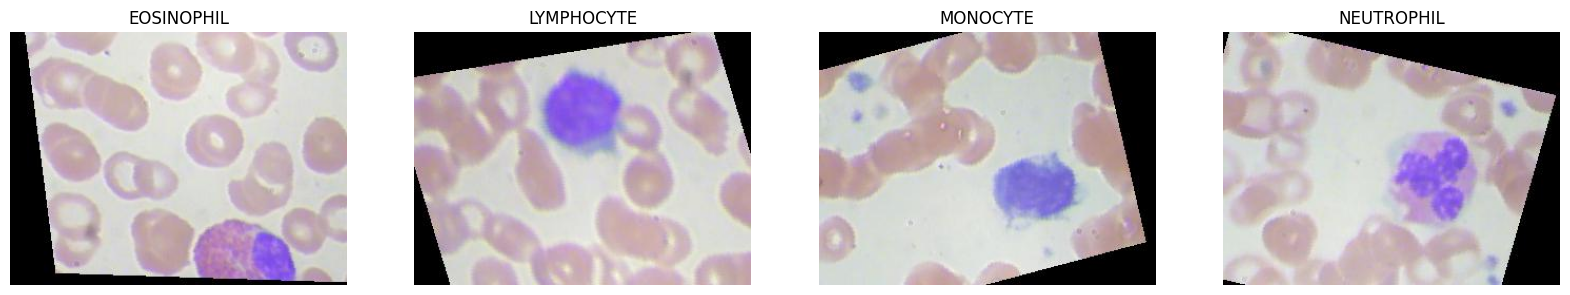

In [ ]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, len(class_names), figsize=(20, 10))
for idx, class_name in enumerate(class_names):
    for img, label in train_loader:
        if label[0] == idx:
            axes[idx].imshow(img[0].permute(1, 2, 0) * 0.5 + 0.5)
            axes[idx].set_title(class_name)
            axes[idx].axis("off")
            break
plt.show()



**Baseline Model**

In [ ]:
use_cuda = True

In [ ]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score

# Paths
data_path = '/content/extracted_dataset/dataset'
classes = ['NEUTROPHIL', 'EOSINOPHIL', 'LYMPHOCYTE', 'MONOCYTE']

# Feature extraction functions
def extract_color_histogram(image, bins=(8, 8, 8)):
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    hist = cv2.calcHist([hsv], [0, 1, 2], None, bins, [0, 180, 0, 256, 0, 256])
    cv2.normalize(hist, hist)
    return hist.flatten()

def extract_edge_features(image):
    edges = cv2.Canny(image, 100, 200)
    return edges.flatten()

# Load dataset and extract features
features = []
labels = []

for class_idx, class_name in enumerate(classes):
    class_folder = os.path.join(data_path, class_name)
    for img_name in os.listdir(class_folder):
        img_path = os.path.join(class_folder, img_name)
        image = cv2.imread(img_path)
        image = cv2.resize(image, (128, 128))  # Resize for uniformity

        # Extract features
        color_hist = extract_color_histogram(image)
        edge_features = extract_edge_features(image)

        # Concatenate features
        feature_vector = np.hstack([color_hist, edge_features])
        features.append(feature_vector)
        labels.append(class_idx)

# Convert to NumPy arrays
features = np.array(features)
labels = np.array(labels)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

# SVM Classifier
svm = SVC(kernel='linear', C=1.0)
svm.fit(X_train, y_train)

# Predictions and Evaluation
y_pred = svm.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred, target_names=classes))


Accuracy: 0.2628617363344051
              precision    recall  f1-score   support

  NEUTROPHIL       0.25      0.28      0.26       649
  EOSINOPHIL       0.24      0.25      0.25       628
  LYMPHOCYTE       0.30      0.29      0.30       597
    MONOCYTE       0.26      0.23      0.25       614

    accuracy                           0.26      2488
   macro avg       0.26      0.26      0.26      2488
weighted avg       0.26      0.26      0.26      2488



**Primary Model**

In [ ]:
import os
import torch
import torchvision.models
resnet = torchvision.models.resnet50(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
directory = '/content/extracted_dataset/dataset'
classes = ['NEUTROPHIL', 'EOSINOPHIL', 'LYMPHOCYTE', 'MONOCYTE']
resnet_features = torch.nn.Sequential(*list(resnet.children())[:-1])


In [ ]:
use_cuda = True

In [ ]:
if torch.cuda.is_available():
    resnet_features = resnet_features.cuda()

In [ ]:
def save_resnet_features(dataloader, set_name):
    features = []
    labels = []

    with torch.no_grad():
        for imgs, lbls in dataloader:
            if use_cuda and torch.cuda.is_available():
                imgs = imgs.cuda()
                lbls = lbls.cuda()

            # Extract features
            feature = resnet_features(imgs)
            features.append(feature)
            labels.append(lbls)

    # Concatenate and save
    features = torch.cat(features)
    labels = torch.cat(labels)

    torch.save(features, os.path.join(directory, f'{set_name}_features.pt'))
    torch.save(labels, os.path.join(directory, f'{set_name}_labels.pt'))
    print(features.shape)

save_resnet_features(train_loader, 'train')
save_resnet_features(val_loader, 'val')
save_resnet_features(test_loader, 'test')

torch.Size([9948, 2048, 1, 1])
torch.Size([1243, 2048, 1, 1])
torch.Size([1245, 2048, 1, 1])


In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class ResNetClassifier(nn.Module):
    def __init__(self):
        super(ResNetClassifier, self).__init__()
        self.fc1 = nn.Linear(2048, 512)
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, 4)  # Adjust based on the number of classes

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten feature map
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [ ]:
import torch.optim as optim
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def train(classifier, train_features, train_labels, val_features, val_labels, learning_rate=0.001, batch_size=64, num_epochs=30):
    optimizer = optim.Adam(classifier.parameters(), lr=learning_rate)
    criterion = nn.CrossEntropyLoss()

    # Prepare DataLoaders for the extracted features
    train_data = torch.utils.data.TensorDataset(train_features, train_labels)
    val_data = torch.utils.data.TensorDataset(val_features, val_labels)
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)

    # Initialize tracking lists
    train_acc_list, val_acc_list = [], []
    train_loss_list, val_loss_list = [], [] # Initialize lists to store losses

    for epoch in range(num_epochs):
        classifier.train()
        total_train_loss = 0

        # Training phase
        correct_train = 0
        total_train = 0
        for features, labels in train_loader:
            features, labels = features.to(device), labels.to(device)
            outputs = classifier(features)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_train_loss += loss.item()

            # Calculate training accuracy
            _, predicted = torch.max(outputs, 1)
            correct_train += (predicted == labels).sum().item()
            total_train += labels.size(0)

        # Calculate average training loss for the epoch
        avg_train_loss = total_train_loss / len(train_loader)
        train_loss_list.append(avg_train_loss)

        # Validation phase
        classifier.eval()
        correct_val = 0
        total_val = 0
        total_val_loss = 0 # Initialize total validation loss for the epoch
        with torch.no_grad():
            for features, labels in val_loader:
                features, labels = features.to(device), labels.to(device)
                outputs = classifier(features)
                loss = criterion(outputs, labels) # Calculate validation loss
                total_val_loss += loss.item() # Accumulate validation loss

                _, predicted = torch.max(outputs, 1)
                correct_val += (predicted == labels).sum().item()
                total_val += labels.size(0)

        # Calculate average validation loss for the epoch
        avg_val_loss = total_val_loss / len(val_loader)
        val_loss_list.append(avg_val_loss)

        # Calculate and store accuracy
        train_acc = 100 * correct_train / total_train
        val_acc = 100 * correct_val / total_val
        train_acc_list.append(train_acc)
        val_acc_list.append(val_acc)

        print(f"Epoch [{epoch+1}/{num_epochs}], "
              f"Train Accuracy: {train_acc:.2f}%, "
              f"Validation Accuracy: {val_acc:.2f}%, "
              f"Train Loss: {avg_train_loss:.4f}, "
              f"Validation Loss: {avg_val_loss:.4f}")

    return train_acc_list, val_acc_list, num_epochs, train_loss_list, val_loss_list # Return both loss lists

In [ ]:
net = ResNetClassifier()
if use_cuda and torch.cuda.is_available():
    net.cuda()

#classifier, train_features, train_labels, val_features, val_labels, learning_rate=0.001, batch_size=32, num_epochs=10
train_features = torch.load(os.path.join(directory, 'train_features.pt'))
train_labels = torch.load(os.path.join(directory, 'train_labels.pt'))
val_features = torch.load(os.path.join(directory, 'val_features.pt'))
val_labels = torch.load(os.path.join(directory, 'val_labels.pt'))

train_acc_list, val_acc_list, epochs, train_loss, val_loss = train(net, train_features, train_labels, val_features, val_labels) # Receive both loss lists

def get_accuracy(model, data_loader):
    correct = 0
    total = 0

    if use_cuda and torch.cuda.is_available():
        resnet_features.cuda()

    for imgs, labels in data_loader:
        if use_cuda and torch.cuda.is_available():
            imgs = imgs.cuda()
            labels = labels.cuda()

        features = resnet_features(imgs)

        output = model(features)
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += imgs.shape[0]
    return correct / total

# Test Accuracy
test_acc = get_accuracy(net, test_loader)
print("Test Accuracy: ", test_acc)

# Validation Accuracy
val_acc = get_accuracy(net, val_loader)
print("Validation Accuracy: ", val_acc)


<ipython-input-22-5a11001b9299>:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  train_features = torch.load(os.path.join(directory, 'train_features.pt'))
<ipython-input-22-

Epoch [1/30], Train Accuracy: 48.86%, Validation Accuracy: 63.64%, Train Loss: 1.1264, Validation Loss: 0.8570
Epoch [2/30], Train Accuracy: 65.05%, Validation Accuracy: 68.06%, Train Loss: 0.8175, Validation Loss: 0.7394
Epoch [3/30], Train Accuracy: 70.73%, Validation Accuracy: 71.44%, Train Loss: 0.7217, Validation Loss: 0.7074
Epoch [4/30], Train Accuracy: 73.08%, Validation Accuracy: 70.72%, Train Loss: 0.6626, Validation Loss: 0.6851
Epoch [5/30], Train Accuracy: 74.17%, Validation Accuracy: 73.93%, Train Loss: 0.6437, Validation Loss: 0.6355
Epoch [6/30], Train Accuracy: 75.33%, Validation Accuracy: 72.08%, Train Loss: 0.5978, Validation Loss: 0.6464
Epoch [7/30], Train Accuracy: 78.72%, Validation Accuracy: 78.84%, Train Loss: 0.5304, Validation Loss: 0.5510
Epoch [8/30], Train Accuracy: 79.22%, Validation Accuracy: 70.56%, Train Loss: 0.5117, Validation Loss: 0.7801
Epoch [9/30], Train Accuracy: 78.10%, Validation Accuracy: 79.16%, Train Loss: 0.5277, Validation Loss: 0.5086
E

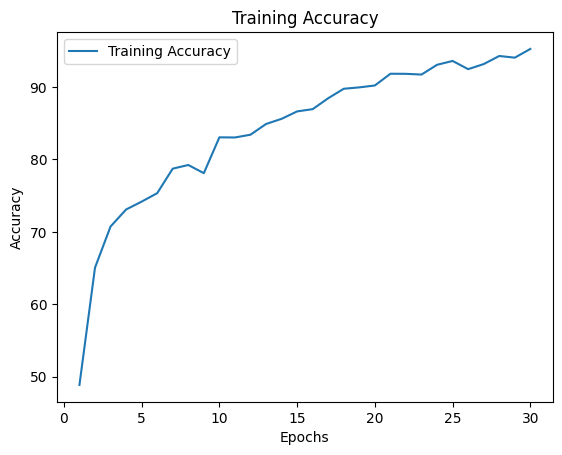

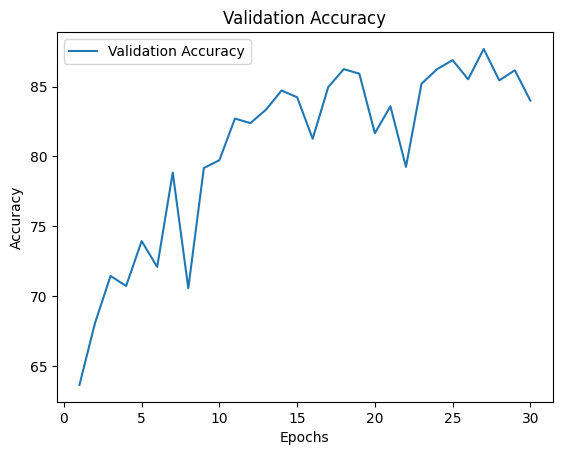

In [ ]:
# Generate a list of epoch numbers
epoch_range = range(1, epochs + 1)

# Plot training accuracy
plt.plot(epoch_range, train_acc_list, label="Training Accuracy")
plt.title("Training Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

# Plot validation accuracy
plt.plot(epoch_range, val_acc_list, label="Validation Accuracy")
plt.title("Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

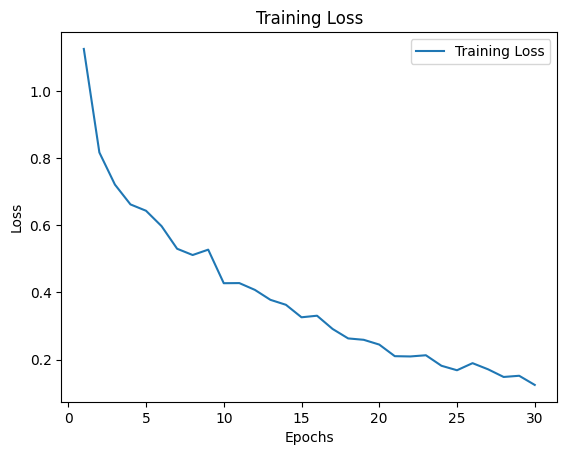

In [ ]:


plt.plot(epoch_range, train_loss, label="Training Loss")
plt.title("Training Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()


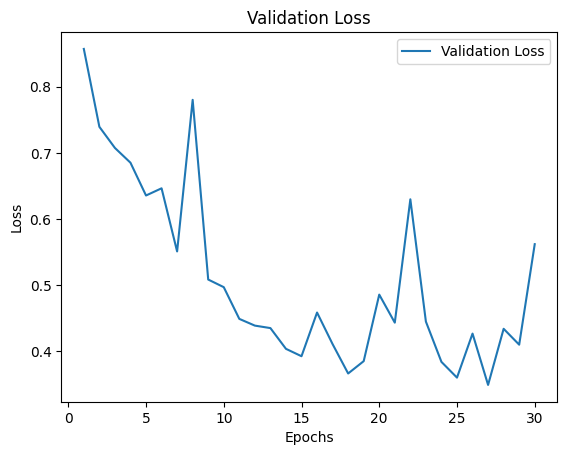

In [ ]:
plt.plot(epoch_range, val_loss, label="Validation Loss")
plt.title("Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()